### Goal
Analyse the outcome of the Linear Regression using a PCA n_comp = 50 for feature reduction.

### TODO

0.0 Load data<br/>

1.1. Compute PCA over the blood train samples (no redundancy)<br/>
1.2. Compute KernelPCA over the blood train samples (no redundancy)<br/>
1.3  Compute linear regression for Blood to Muscle

### Conclusions

1. PCA tissue specific:
    - for Fallopian Tube, Cervix (Ecto-, Endocervix) and Bladder we cannot compute PCA with 10 components (4 Tissues)
    - for 49 Tissues we could compute the 10 components PCA
    - PCA tissue specific model reduces the gene space from 19932 to 490 features
    

In [22]:
# top candidates

top_individuals = ['GTEX-ZAB4',
                    'GTEX-12WSD',
                     'GTEX-13OW6',
                     'GTEX-131YS',
                     'GTEX-NPJ8',
                     'GTEX-11GSP',
                     'GTEX-YFC4',
                     'GTEX-13OVJ',
                     'GTEX-13OW8',
                     'GTEX-12ZZX']
top_highvariance_genes = ['ENSG00000171195.10',
                         'ENSG00000124233.11',
                         'ENSG00000169344.15',
                         'ENSG00000172179.11',
                         'ENSG00000259384.6',
                         'ENSG00000204414.11',
                         'ENSG00000279857.1',
                         'ENSG00000135346.8',
                         'ENSG00000164822.4',
                         'ENSG00000164816.7']
top_lowvariance_genes = ['ENSG00000262526.2',
                         'ENSG00000131143.8',
                         'ENSG00000173812.10',
                         'ENSG00000104904.12',
                         'ENSG00000170315.13',
                         'ENSG00000105185.11',
                         'ENSG00000123349.13',
                         'ENSG00000156976.15',
                         'ENSG00000197746.13',
                         'ENSG00000172757.12']
top_tissues = ['Muscle - Skeletal',
             'Skin - Sun Exposed (Lower leg)',
             'Adipose - Subcutaneous',
             'Lung',
             'Artery - Tibial',
             'Thyroid',
             'Nerve - Tibial',
             'Esophagus - Mucosa',
             'Cells - Transformed fibroblasts',
             'Esophagus - Muscularis',
             'Heart - Left Ventricle',
             'Skin - Not Sun Exposed (Suprapubic)',
             'Artery - Aorta',
             'Adipose - Visceral (Omentum)']

In [23]:
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.externals import joblib
import sklearn as sk
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LassoLarsCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer

import rep.preprocessing_new as prep
import rep.datasets as d
import rep.models as m
import warnings; warnings.simplefilter('ignore')

In [24]:
def tissue_tissue(y_pred, y_valid, metadata_samples,  n_top, individual, tissue, genes, plot_axes = None):
    
    palette = sns.color_palette(None, n_top).as_hex()
    n = n_top - 1 
    # scatterplot values blood against brain 
    x = np.array([])
    y = np.array([])
    s = np.array([])
    
    # slice by individual
    index_by_indiv = metadata_samples[metadata_samples['Individual']==individual].index.tolist()
    pos_index_by_indiv = [metadata_samples.index.get_loc(ind) for ind in index_by_indiv]
    
    index_by_tissue = metadata_samples[metadata_samples['To_tissue']==tissue].index.tolist()
    pos_index_by_tissue = [metadata_samples.index.get_loc(ind) for ind in index_by_tissue]

    
    pos = list(set(pos_index_by_indiv) & set(pos_index_by_tissue))
    if len(pos) > 0:
        pos_index_by_gene = [i for i, gene in enumerate(genes)]
        x =  y_pred[pos[0],pos_index_by_gene].flatten()
        y =  y_valid[pos[0],pos_index_by_gene].flatten() 

        x_label = 'Pred'
        y_label = 'Obs'
        data = pd.DataFrame(data = {x_label:x, y_label:y})
        ax = sns.scatterplot(x=x_label, y=y_label, data=data, ax = plot_axes, alpha = 0.5)
#         ax.set(ylim=(-7, 7), xlim=(-7,7), title=individual + " " + tissue, xmargin=10, ymargin=10)
        
def plot(y_pred, y_valid, metadata_samples, n_top, genes):  
    f, axes = plt.subplots(2, len(top_tissues[:5]),figsize=(30,10))

    for j,tissue in enumerate(top_tissues[:5]):
        top_individuals = list(set(metadata_samples[metadata_samples['To_tissue']==tissue]['Individual'].tolist()))
        for i,indiv in enumerate(top_individuals[:2]):
            tissue_tissue(y_pred, y_valid, metadata_samples,  n_top, indiv, tissue, genes, axes[i][j])     

### 0. Load train/valid datasets

In [25]:
y_targets_h5 = "/s/project/rep/processed/gtex/input_data/Y_targets_pc_onlyblood.h5"
x_inputs_h5 = "/s/project/rep/processed/gtex/input_data/X_inputs_pc_onlyblood.h5"
train_dataset, valid_dataset = d.rep_blood_expression(x_inputs_h5, y_targets_h5, label=None)

metadata_samples_train, metadata_samples_valid = train_dataset.metadata, valid_dataset.metadata
features_train, features_valid = train_dataset.features, valid_dataset.features
x_train, y_train = train_dataset.inputs, train_dataset.targets
x_valid, y_valid = valid_dataset.inputs, valid_dataset.targets

### 1.1 Compute PCA over the blood train samples (no redundancy)

In [73]:
# model 
file = "/data/ouga/home/ag_gagneur/giurgiu/rep_gagneur/rep/rep/gin_runs/test/7faca89b-34dc-4cf7-b215-6dea159e8a6b/model.h5"
model = joblib.load(file)

y_true = y_valid
y_pred = model.predict(x_valid)

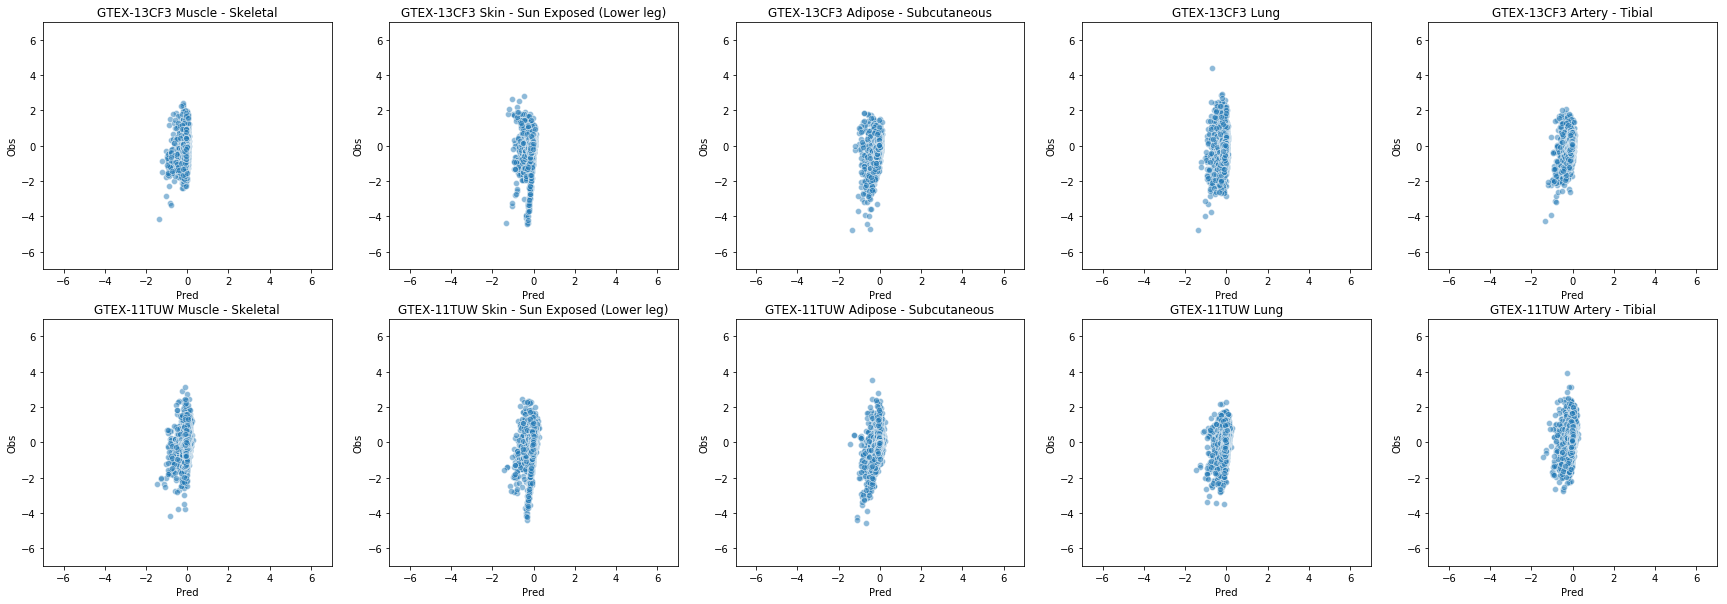

In [97]:
plot(y_pred, y_valid, metadata_samples_valid, 10, features_valid['gene_id'].tolist())

### 1.2 Compute KernelPCA over the blood train samples (no redundancy)


In [26]:
# load gtex data
features_file = "/s/project/rep/processed/gtex/recount/recount_gtex_logratios.h5ad"
train_individuals_file = "/s/project/rep/processed/gtex/recount/train_individuals.txt"
train_individuals = prep.read_csv_one_column(train_individuals_file)
gtex = prep.RepAnnData.read_h5ad(features_file)
gtex_filtered = gtex[gtex.samples['Individual'].isin(train_individuals)]
del gtex

# compute PCA
pca_model = None
n_components = 200
t = 'Whole Blood'
features = gtex_filtered[gtex_filtered.obs['Tissue'] == t].X
if features.shape[0] >= n_components:
    pca_model = m.pca_train(pca_type = KernelPCA, n_components = n_components, features_file = features_file, train_individuals_file = train_individuals_file,tissue = t)
else:
    print(f'Warning! cannot compute PCA for {t} because there are only {features.shape[0]} available samples')
del features

Start <class 'sklearn.decomposition.kernel_pca.KernelPCA'> with 200 for 238 individuals and 19932 genes


In [27]:
cv = 5
max_iter = 50
normalize = False
n_jobs = 1

dim_reducer = pca_model
p = Pipeline(steps=[('StandardScaler',StandardScaler()),
                    ('DimReducer', dim_reducer),
                    ('LassoLarsMultiOutputRegressor', MultiOutputRegressor(LassoLarsCV(cv=cv, max_iter=max_iter, normalize=normalize, n_jobs=n_jobs), n_jobs=5))])

In [28]:
model = p.fit(x_train, y_train)

In [29]:
y_true = y_valid
y_pred = model.predict(x_valid)

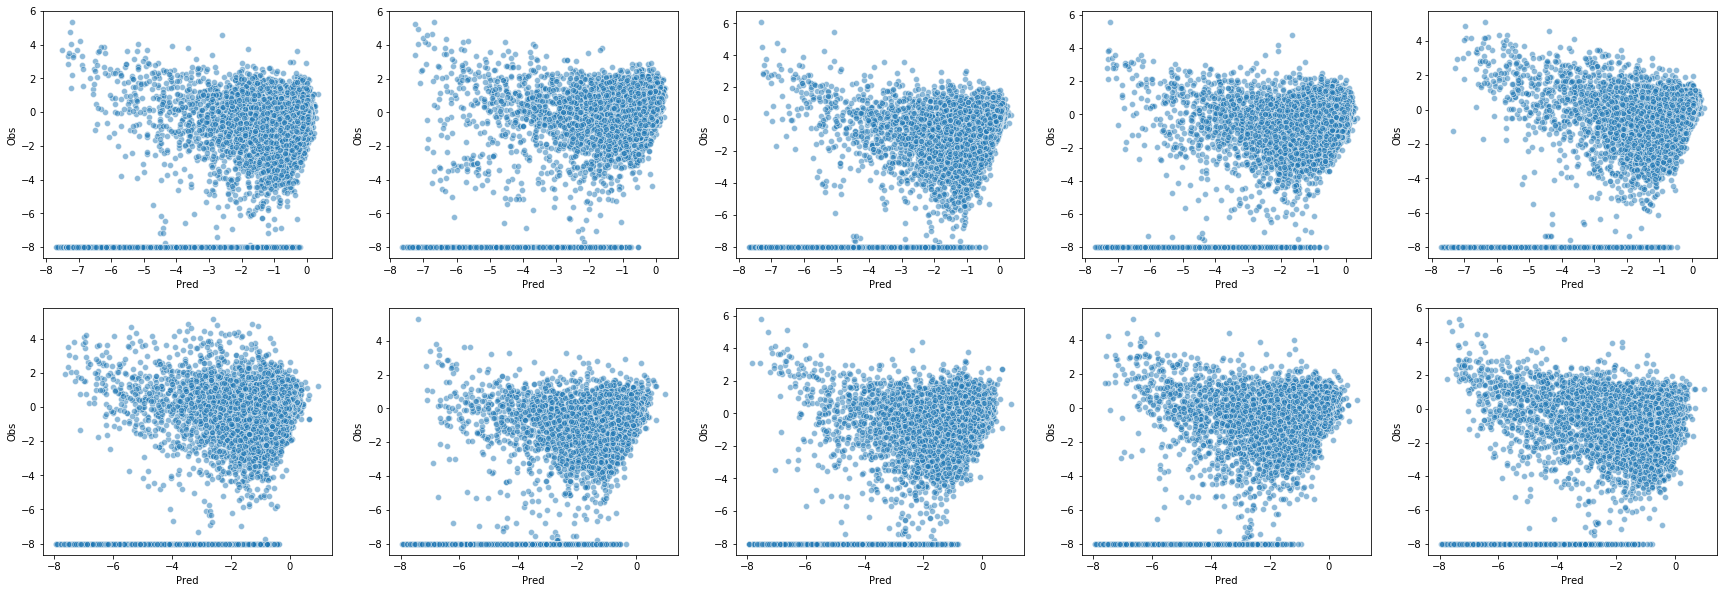

In [30]:
plot(y_pred, y_true, metadata_samples_valid, 10, features_valid['gene_id'].tolist())

In [31]:
y_pred[:3]

array([[-0.17460891, -1.07141098, -0.06332182, ..., -0.98258988,
        -0.48484463, -0.15264958],
       [-0.17460891, -1.07141098, -0.06332182, ..., -0.98258988,
        -0.48484464, -0.15264958],
       [-0.17460891, -1.07141098, -0.06332182, ..., -0.98258988,
        -0.48484464, -0.15264958]])

In [32]:
y_true[:3]

array([[-0.11073493, -0.02070045, -0.0272231 , ..., -1.3149759 ,
        -0.536643  , -0.48919886],
       [ 0.18079662,  1.3634684 ,  0.15382004, ..., -1.7400677 ,
        -0.38181472, -0.02810514],
       [ 0.93012476,  2.7239823 , -0.05612755, ...,  1.6064026 ,
         0.33533525,  0.5809711 ]], dtype=float32)

### 1.3 Compute linear regression for Blood to Muscle 
In order to validate our approach, we consider only the data samples which go from blood to muscle

In [33]:
y_targets_h5 = "/s/project/rep/processed/gtex/input_data/Y_targets_pc_onlyblood.h5"
x_inputs_h5 = "/s/project/rep/processed/gtex/input_data/X_inputs_pc_onlyblood.h5"
x = prep.RepAnnData.read_h5ad(x_inputs_h5)
y = prep.RepAnnData.read_h5ad(y_targets_h5)

In [34]:
xs = x[x.samples['To_tissue']=='Muscle - Skeletal']

x_train_short = xs[xs.obs['Type']=='train']
metadata = x_train_short.obs
features = x_train_short.var
x_train_short = np.array(x_train_short.X)

x_valid_short = np.array(xs[xs.obs['Type']=='valid'].X)

ys = y[y.samples['To_tissue']=='Muscle - Skeletal']
y_train_short = np.array(ys[ys.obs['Type']=='train'].X)
y_valid_short = np.array(ys[ys.obs['Type']=='valid'].X)

# avoid 0 columns - lassoLars expection
x_train_short[0,:] = x_train_short[0,:] + 0.00000001
y_train_short[0,:] = y_train_short[0,:] + 0.00000001
x_valid_short[0,:] = x_valid_short[0,:] + 0.00000001
y_valid_short[0,:] = y_valid_short[0,:] + 0.00000001

del xs, ys, x, y

In [35]:
model = p.fit(x_train_short, y_train_short)
y_true = y_valid_short
y_pred = model.predict(x_valid_short)

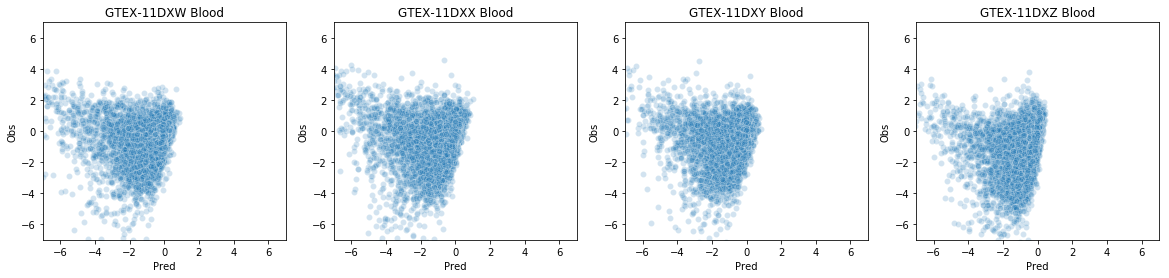

In [36]:
x_label = 'Pred'
y_label = 'Obs'
color_label = metadata['Individual'].tolist()

f, axes = plt.subplots(1,4,figsize=(20,4))

for i in range(0,4):
    data = pd.DataFrame(data = {x_label:y_pred[i,:], y_label:y_true[i,:]})
    ax = sns.scatterplot(x=x_label, y=y_label, data=data, alpha = 0.2, ax=axes[i])
    ax.set(ylim=(-7, 7), xlim=(-7,7), title= color_label[i] + " Blood", xmargin=10, ymargin=10)        

### 2. PCA - compute PCA tissue specific
We need in the model some latents which points to the tissue specificity.<br/>
One idea is to compute PCA tissue specific and merge the models

In [99]:
import numpy as np
import pandas as pd

import sklearn as sk
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LassoLarsCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer

import rep.preprocessing_new as p
import rep.datasets as d
import rep.models as m
import warnings; warnings.simplefilter('ignore')

In [101]:
# load gtex data
features_file = "/s/project/rep/processed/gtex/recount/recount_gtex_logratios.h5ad"
train_individuals_file = "/s/project/rep/processed/gtex/recount/train_individuals.txt"
train_individuals = p.read_csv_one_column(train_individuals_file)
gtex = p.RepAnnData.read_h5ad(features_file)
gtex_filtered = gtex[gtex.samples['Individual'].isin(train_individuals)]
del gtex

In [102]:
# compute PCA
pca_model = None
n_components = 200
t = 'Whole Blood'
features = gtex_filtered[gtex_filtered.obs['Tissue'] == t].X
if features.shape[0] >= n_components:
    pca_model = m.pca_train(n_components = n_components, features_file = features_file, train_individuals_file = train_individuals_file,tissue = t)
else:
    print(f'Warning! cannot compute PCA for {t} because there are only {features.shape[0]} available samples')
del features

Start <class 'sklearn.decomposition.pca.PCA'> with 200 for 238 individuals and 19932 genes


In [103]:
train_dataset.inputs.shape, train_dataset.targets.shape,  valid_dataset.inputs.shape, valid_dataset.targets.shape

((4403, 19932), (4403, 19932), (1630, 19932), (1630, 19932))

In [104]:
# add categorical values to model
train_data = pd.DataFrame(data=train_dataset.inputs, columns=gtex_filtered.var_names)
train_data['Tissue'] = pd.Series(train_dataset.metadata['To_tissue'].tolist(), index=train_data.index).astype(str)

valid_data = pd.DataFrame(data=valid_dataset.inputs, columns=gtex_filtered.var_names)
valid_data['Tissue'] = pd.Series(valid_dataset.metadata['To_parent_tissue'].tolist(), index=valid_data.index).astype(str)

In [106]:
# all genes
features_annotation = features_train['gene_id'].tolist()

# PCA model
dim_reducer = pca_model

# preprocessing of numeric_features
numeric_features = features_annotation
numeric_transformer = Pipeline(steps=[
    ('StandardScaler', StandardScaler()),
    ('DimensionalityReductionPCA', dim_reducer)])

In [108]:
# preprocessing tissue category
categorical_features = ['Tissue']
categorical_transformer = Pipeline(steps=[
    ('OneHot', OneHotEncoder(handle_unknown='ignore'))])
categorical_transformer

Pipeline(memory=None,
     steps=[('OneHot', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True))])

In [109]:
# pipeline transformation
cv = 5
max_iter = 50
normalize = False
n_jobs = 1
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

p = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('LassoLarsMultiOutputRegressor',
               MultiOutputRegressor(LassoLarsCV(cv=cv, max_iter=max_iter, normalize=normalize, n_jobs=n_jobs),
                                    n_jobs=5))])

In [110]:
model = p.fit(train_data, y_train)

In [111]:
y_true = y_valid
y_pred = model.predict(valid_data)

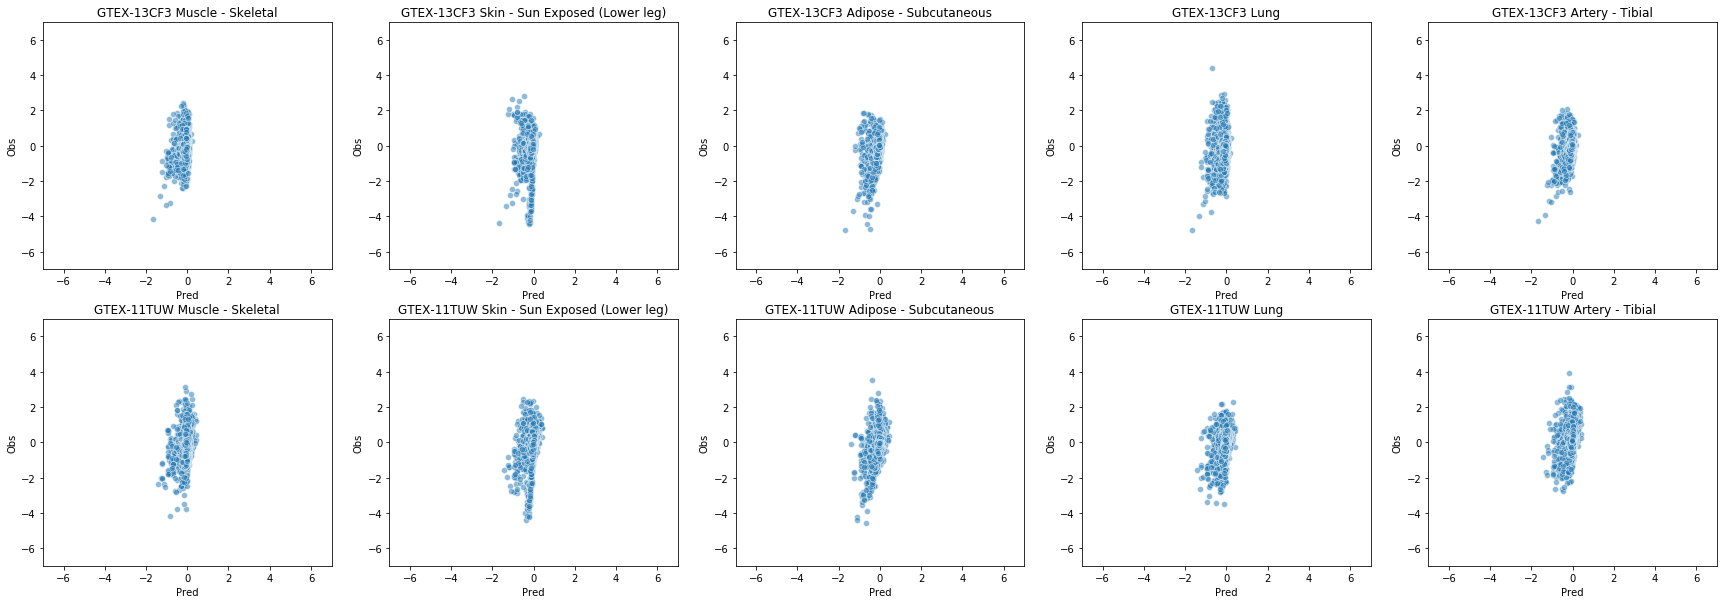

In [112]:
plot(y_pred, y_valid, metadata_samples_valid, 10, features_valid['gene_id'].tolist())

In [11]:
# OneHotEncoded manually

# onehot = OneHotEncoder(handle_unknown='ignore')
# enc = onehot.fit_transform(train_data.loc[:,['Tissue']])

# scalerx = StandardScaler()
# scalery = StandardScaler()
# X_train = scalerx.fit_transform(train_dataset.inputs)
# Y_train = scalery.fit_transform(train_dataset.targets)
# pca = pca_model.fit_transform(X_train)

# preprocessor = np.concatenate((pca,enc.todense()), axis=1)
# preprocessor.shape

# reg = MultiOutputRegressor(LassoLarsCV(cv=cv, max_iter=max_iter, normalize=normalize, n_jobs=n_jobs), n_jobs=5)

# model = reg.fit(preprocessor,Y_train)

# X_valid = scalerx.fit_transform(valid_dataset.inputs)
# y_valid = scalery.fit_transform(valid_dataset.targets)

# y_pred = model.predict(np.concatenate((pca_model.transform(X_valid), 
#                                            onehot.transform(valid_data.loc[:,['Tissue']]).todense()), axis=1))

### Normalized PCA
The resulting projections are well balanced, aiming at
preserving both large and small pairwise distances. We have
found this method, which we call normalized PCA, to be
superior to the standard PCA, especially when the data
contain outliers. https://ieeexplore-ieee-org.eaccess.ub.tum.de/stamp/stamp.jsp?tp=&arnumber=1298803